<a href="https://www.kaggle.com/code/vikarna/churn-prediction?scriptVersionId=94680568" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Customer churn occurs when customers or subscribers stop doing business with a company or service, also known as customer attrition. It is also referred as loss of clients or customers. One industry in which churn rates are particularly useful is the telecommunications industry, because most customers have multiple options from which to choose within a geographic location.
Similar concept with predicting employee turnover, we are going to predict customer churn using telecom dataset.

In [19]:
library(plyr)
library(corrplot)
library(ggplot2)
library(gridExtra)
library(ggthemes)
library(caret)
library(MASS)
library(randomForest)
library(party)
library(readxl)
churn <- read.csv('../input/telecom-churn-dataset-ibm/WA_Fn-UseC_-Telco-Customer-Churn.csv')
str(churn)

'data.frame':	7043 obs. of  21 variables:
 $ customerID      : Factor w/ 7043 levels "0002-ORFBO","0003-MKNFE",..: 5376 3963 2565 5536 6512 6552 1003 4771 5605 4535 ...
 $ gender          : Factor w/ 2 levels "Female","Male": 1 2 2 2 1 1 2 1 1 2 ...
 $ SeniorCitizen   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ Partner         : Factor w/ 2 levels "No","Yes": 2 1 1 1 1 1 1 1 2 1 ...
 $ Dependents      : Factor w/ 2 levels "No","Yes": 1 1 1 1 1 1 2 1 1 2 ...
 $ tenure          : int  1 34 2 45 2 8 22 10 28 62 ...
 $ PhoneService    : Factor w/ 2 levels "No","Yes": 1 2 2 1 2 2 2 1 2 2 ...
 $ MultipleLines   : Factor w/ 3 levels "No","No phone service",..: 2 1 1 2 1 3 3 2 3 1 ...
 $ InternetService : Factor w/ 3 levels "DSL","Fiber optic",..: 1 1 1 1 2 2 2 1 2 1 ...
 $ OnlineSecurity  : Factor w/ 3 levels "No","No internet service",..: 1 3 3 3 1 1 1 3 1 3 ...
 $ OnlineBackup    : Factor w/ 3 levels "No","No internet service",..: 3 1 3 1 1 1 3 1 1 3 ...
 $ DeviceProtection: Factor w/ 3 levels "No","

customerID

gender (female, male)

SeniorCitizen (Whether the customer is a senior citizen or not (1, 0))

Partner (Whether the customer has a partner or not (Yes, No))

Dependents (Whether the customer has dependents or not (Yes, No))

tenure (Number of months the customer has stayed with the company)

PhoneService (Whether the customer has a phone service or not (Yes, No))

MultipleLines (Whether the customer has multiple lines r not (Yes, No, No phone service)

InternetService (Customer’s internet service provider (DSL, Fiber optic, No)

OnlineSecurity (Whether the customer has online security or not (Yes, No, No internet service)

OnlineBackup (Whether the customer has online backup or not (Yes, No, No internet service)

DeviceProtection (Whether the customer has device protection or not (Yes, No, No internet service)

TechSupport (Whether the customer has tech support or not (Yes, No, No internet service)

streamingTV (Whether the customer has streaming TV or not (Yes, No, No internet service)

streamingMovies (Whether the customer has streaming movies or not (Yes, No, No internet service)

Contract (The contract term of the customer (Month-to-month, One year, Two year)

PaperlessBilling (Whether the customer has paperless billing or not (Yes, No))

PaymentMethod (The customer’s payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)))

MonthlyCharges (The amount charged to the customer monthly — numeric)

TotalCharges (The total amount charged to the customer — numeric)

Churn ( Whether the customer churned or not (Yes or No))


The raw data contains 7043 rows (customers) and 21 columns (features). The “Churn” column is our target.

checking missing values


In [20]:
sapply(churn, function(x) sum(is.na(x)))

customerID           gender    SeniorCitizen          Partner 
               0                0                0                0 
      Dependents           tenure     PhoneService    MultipleLines 
               0                0                0                0 
 InternetService   OnlineSecurity     OnlineBackup DeviceProtection 
               0                0                0                0 
     TechSupport      StreamingTV  StreamingMovies         Contract 
               0                0                0                0 
PaperlessBilling    PaymentMethod   MonthlyCharges     TotalCharges 
               0                0                0               11 
           Churn 
               0

In [21]:
churn <- churn[complete.cases(churn), ]

We will change “No internet service” to “No” for six columns, they are: “OnlineSecurity”, “OnlineBackup”, “DeviceProtection”, “TechSupport”, “streamingTV”, “streamingMovies”.

In [22]:
cols_recode1 <- c(10:15)
for(i in 1:ncol(churn[,cols_recode1])) {
        churn[,cols_recode1][,i] <- as.factor(mapvalues
                                              (churn[,cols_recode1][,i], from =c("No"),to=c("No")))
}

We will change “No phone service” to “No” for column “MultipleLines”

In [23]:
churn$MultipleLines <- as.factor(mapvalues(churn$MultipleLines, 
                                           from=c("No"),
                                           to=c("No")))

Since the minimum tenure is 1 month and maximum tenure is 72 months, we can group them into five tenure groups: “0–12 Month”, “12–24 Month”, “24–48 Months”, “48–60 Month”, “> 60 Month”

In [24]:
min(churn$tenure); max(churn$tenure)

[1] 1

[1] 72

In [25]:
group_tenure <- function(tenure){
    if (tenure >= 0 & tenure <= 12){
        return('0-12 Month')
    }else if(tenure > 12 & tenure <= 24){
        return('12-24 Month')
    }else if (tenure > 24 & tenure <= 48){
        return('24-48 Month')
    }else if (tenure > 48 & tenure <=60){
        return('48-60 Month')
    }else if (tenure > 60){
        return('> 60 Month')
    }
}
churn$tenure_group <- sapply(churn$tenure,group_tenure)
churn$tenure_group <- as.factor(churn$tenure_group)

Change the values in column “SeniorCitizen” from 0 or 1 to “No” or “Yes”.

In [26]:
churn$SeniorCitizen <- as.factor(mapvalues(churn$SeniorCitizen,
                                      from=c("0","1"),
                                      to=c("No", "Yes")))

Remove the columns we do not need for the analysis.

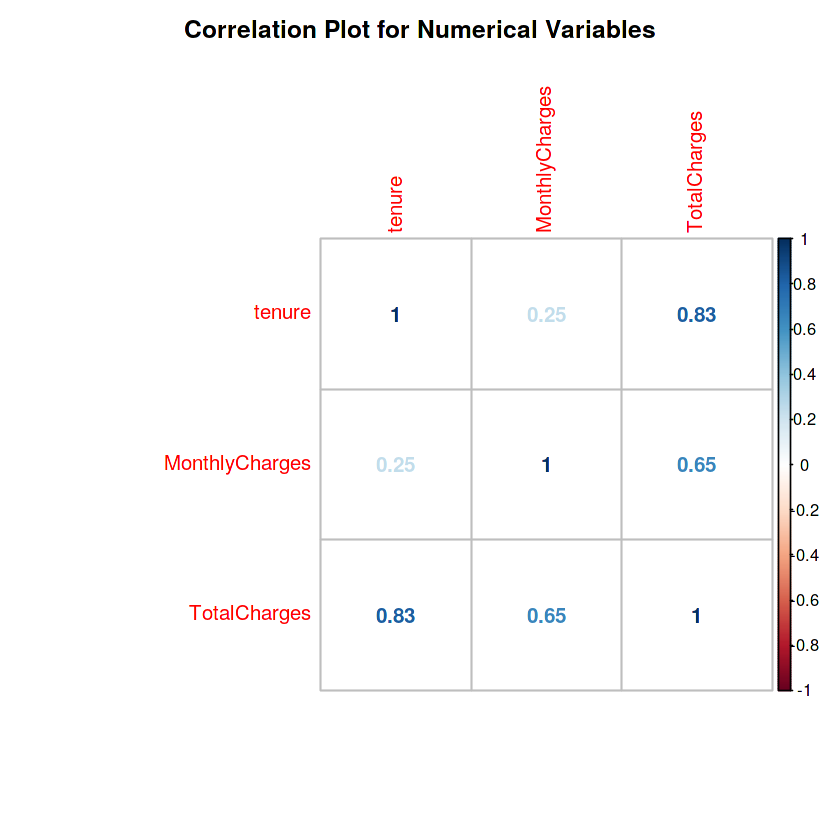

In [27]:
numeric.var <- sapply(churn, is.numeric)
corr.matrix <- cor(churn[,numeric.var])
corrplot(corr.matrix, main="\n\nCorrelation Plot for Numerical Variables", method="number")

The Monthly Charges and Total Charges are correlated. So one of them will be removed from the model. We remove Total Charges.

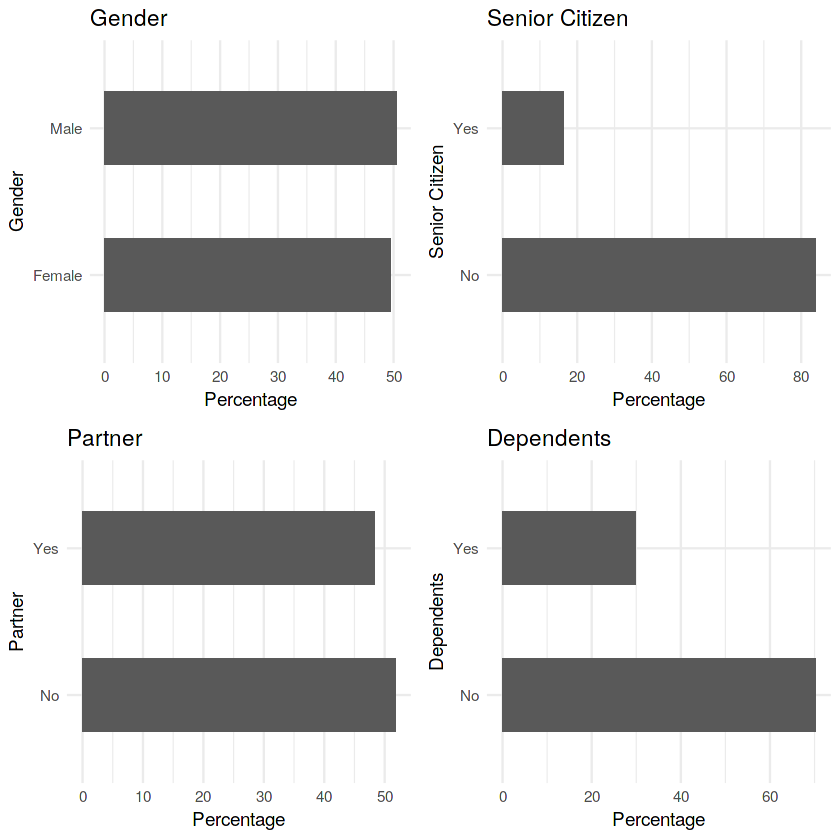

In [28]:
p1 <- ggplot(churn, aes(x=gender)) + ggtitle("Gender") + xlab("Gender") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p2 <- ggplot(churn, aes(x=SeniorCitizen)) + ggtitle("Senior Citizen") + xlab("Senior Citizen") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p3 <- ggplot(churn, aes(x=Partner)) + ggtitle("Partner") + xlab("Partner") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p4 <- ggplot(churn, aes(x=Dependents)) + ggtitle("Dependents") + xlab("Dependents") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
grid.arrange(p1, p2, p3, p4, ncol=2)

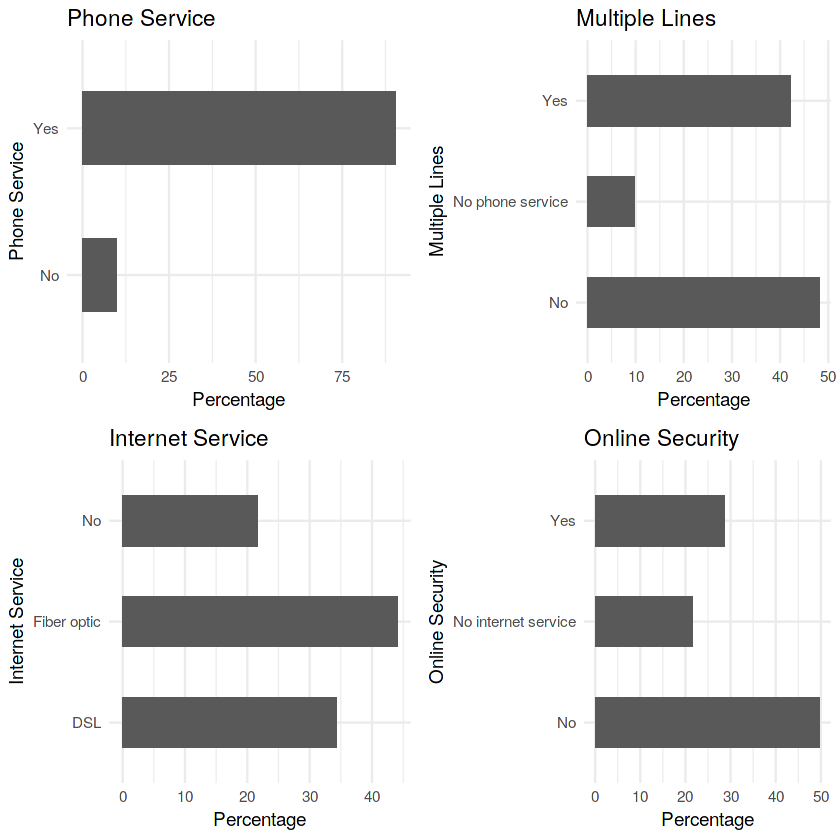

In [29]:
p5 <- ggplot(churn, aes(x=PhoneService)) + ggtitle("Phone Service") + xlab("Phone Service") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p6 <- ggplot(churn, aes(x=MultipleLines)) + ggtitle("Multiple Lines") + xlab("Multiple Lines") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p7 <- ggplot(churn, aes(x=InternetService)) + ggtitle("Internet Service") + xlab("Internet Service") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p8 <- ggplot(churn, aes(x=OnlineSecurity)) + ggtitle("Online Security") + xlab("Online Security") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
grid.arrange(p5, p6, p7, p8, ncol=2)


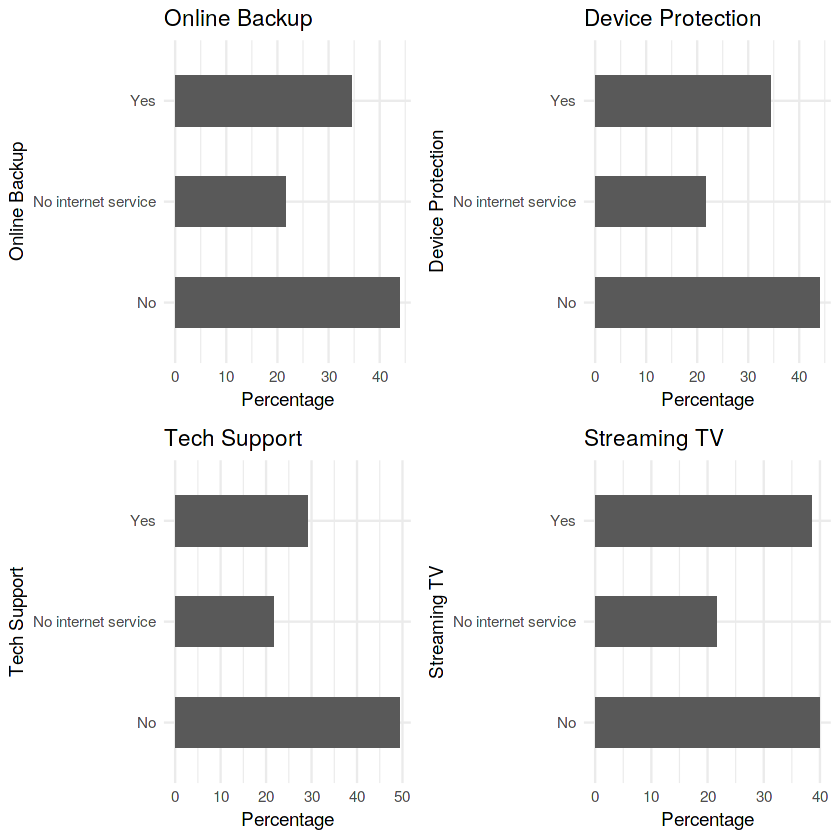

In [30]:
p9 <- ggplot(churn, aes(x=OnlineBackup)) + ggtitle("Online Backup") + xlab("Online Backup") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p10 <- ggplot(churn, aes(x=DeviceProtection)) + ggtitle("Device Protection") + xlab("Device Protection") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p11 <- ggplot(churn, aes(x=TechSupport)) + ggtitle("Tech Support") + xlab("Tech Support") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p12 <- ggplot(churn, aes(x=StreamingTV)) + ggtitle("Streaming TV") + xlab("Streaming TV") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
grid.arrange(p9, p10, p11, p12, ncol=2)


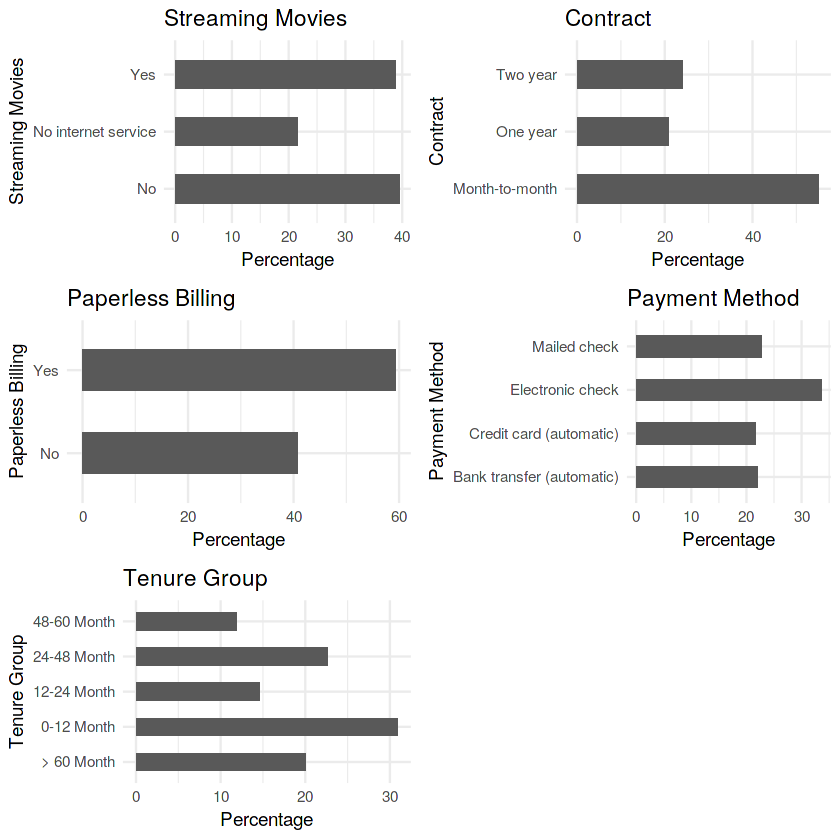

In [31]:
p13 <- ggplot(churn, aes(x=StreamingMovies)) + ggtitle("Streaming Movies") + xlab("Streaming Movies") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p14 <- ggplot(churn, aes(x=Contract)) + ggtitle("Contract") + xlab("Contract") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p15 <- ggplot(churn, aes(x=PaperlessBilling)) + ggtitle("Paperless Billing") + xlab("Paperless Billing") + 
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p16 <- ggplot(churn, aes(x=PaymentMethod)) + ggtitle("Payment Method") + xlab("Payment Method") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
p17 <- ggplot(churn, aes(x=tenure_group)) + ggtitle("Tenure Group") + xlab("Tenure Group") +
  geom_bar(aes(y = 100*(..count..)/sum(..count..)), width = 0.5) + ylab("Percentage") + coord_flip() + theme_minimal()
grid.arrange(p13, p14, p15, p16, p17, ncol=2)

All of the categorical variables seem to have a reasonably broad distribution, therefore, all of them will be kept for the further analysis.

All of the categorical variables seem to have a reasonably broad distribution, therefore, all of them will be kept for the further analysis.

**Logistic Regression** :

we split into training and testing sets


In [32]:
intrain<- createDataPartition(churn$Churn,p=0.7,list=FALSE)
set.seed(2017)
training<- churn[intrain,]
testing<- churn[-intrain,]



In [ ]:
LogModel <- glm(Churn ~ .,family=binomial(link="logit"),data=training)
print(summary(LogModel))

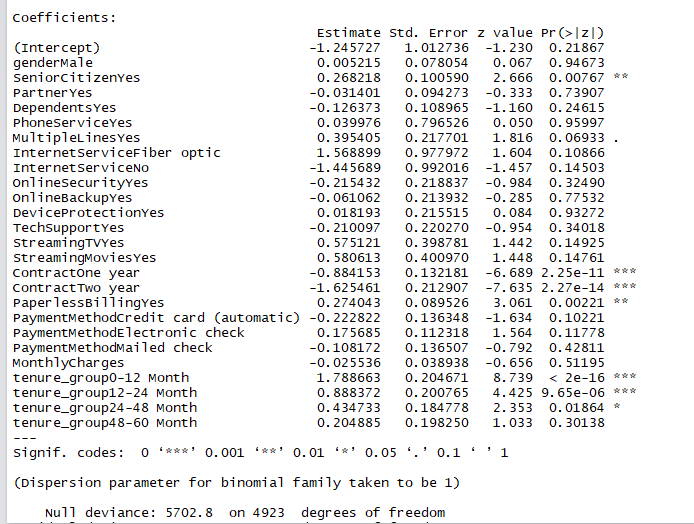


The top three most-relevant features include Contract, tenure_group and PaperlessBilling

In [ ]:
anova(LogModel, test="Chisq")

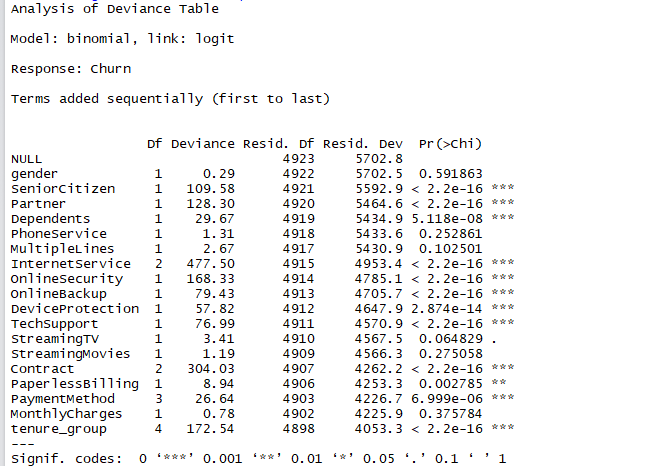

The top three most-relevant features include Contract, tenure_group and PaperlessBilling.

Analyzing the deviance table we can see the drop in deviance when adding each variable one at a time. Adding InternetService, Contract and tenure_group significantly reduces the residual deviance. The other variables such as PaymentMethod and Dependents seem to improve the model less even though they all have low p-values.
Assessing the predictive ability of the Logistic Regression model

In [ ]:
Analyzing the deviance table we can see the drop in deviance when adding each variable one at a time. Adding InternetService, Contract and tenure_group significantly reduces the residual deviance. The other variables such as PaymentMethod and Dependents seem to improve the model less even though they all have low p-values.
Assessing the predictive ability of the Logistic Regression model

Logistic Regression Accuracy 0.789373814041746

In [ ]:
print("Confusion Matrix for Logistic Regression"); table(testing$Churn, fitted.results > 0.5)

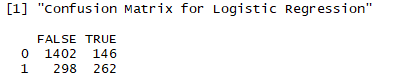


Decision Tree

Decision Tree visualization

For illustration purpose, we are going to use only three variables for plotting Decision Trees, they are “Contract”, “tenure_group” and “PaperlessBilling”.

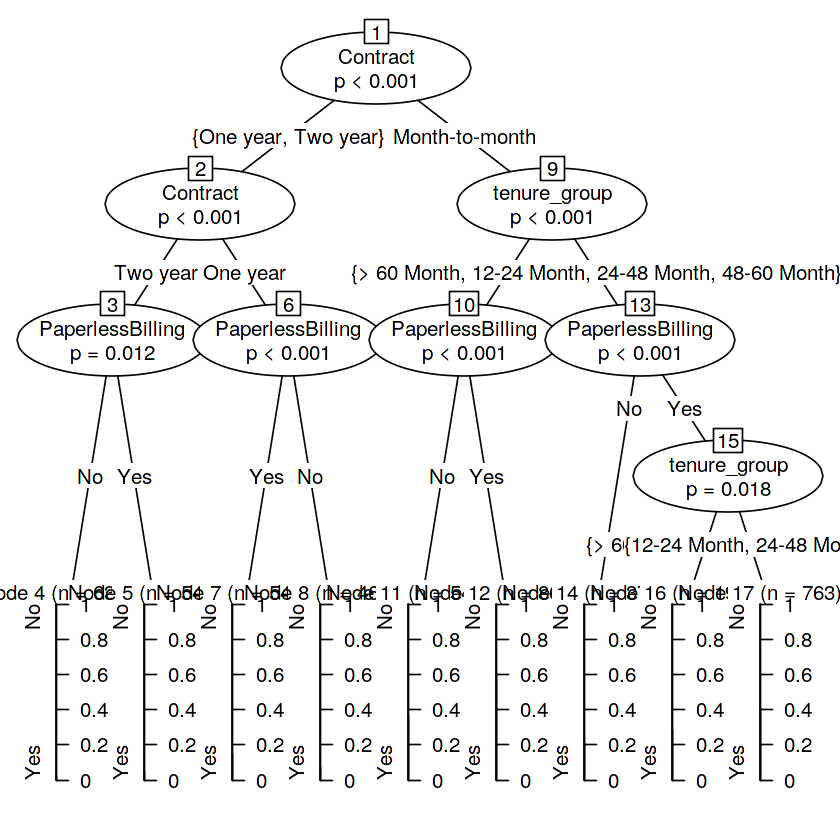

In [33]:
tree <- ctree(Churn~Contract+tenure_group+PaperlessBilling, training)
plot(tree)

Out of three variables we use, Contract is the most important variable to predict customer churn or not churn.

If a customer in a one-year or two-year contract, no matter he (she) has PapelessBilling or not, he (she) is less likely to churn.

On the other hand, if a customer is in a month-to-month contract, and in the tenure group of 0–12 month, and using PaperlessBilling, then this customer is more likely to churn.

In [34]:
pred_tree <- predict(tree, testing)
print("Confusion Matrix for Decision Tree"); table(Predicted = pred_tree, Actual = testing$Churn)

[1] "Confusion Matrix for Decision Tree"


         Actual
Predicted   No  Yes
      No  1398  342
      Yes  150  218

In [35]:
p1 <- predict(tree, training)
tab1 <- table(Predicted = p1, Actual = training$Churn)
tab2 <- table(Predicted = pred_tree, Actual = testing$Churn)
print(paste('Decision Tree Accuracy',sum(diag(tab2))/sum(tab2)))

[1] "Decision Tree Accuracy 0.766603415559772"


**Random Forest**

Random Forest Initial Model

In [36]:
rfModel <- randomForest(Churn ~., data = training)
print(rfModel)


ERROR: Error in randomForest.default(m, y, ...): Can not handle categorical predictors with more than 53 categories.


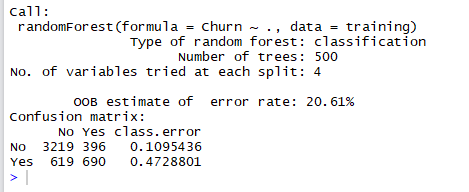

In [ ]:
pred_rf <- predict(rfModel, testing)
caret::confusionMatrix(pred_rf, testing$Churn)

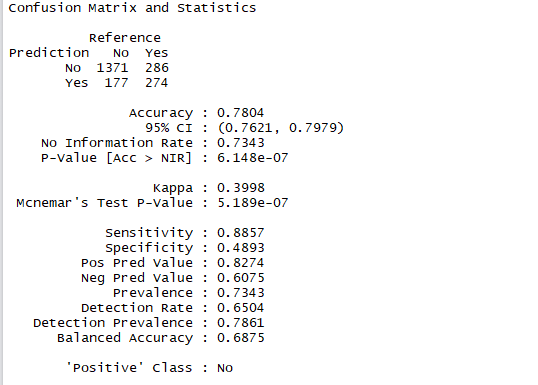

In [ ]:
plot(rfModel)

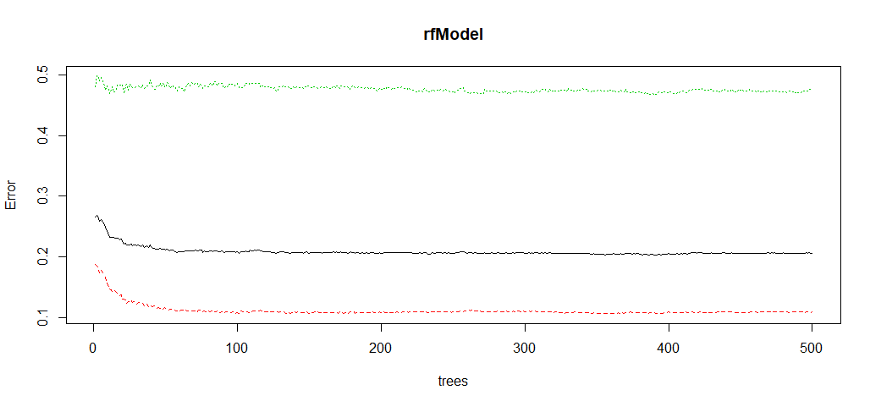

Random Forest Feature Importance


In [ ]:
varImpPlot(rfModel_new, sort=T, n.var = 10, main = 'Top 10 Feature Importance')

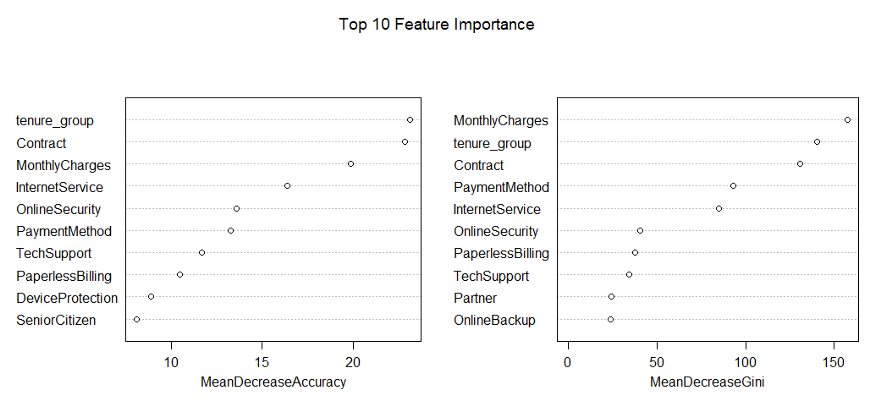

Summary:

From the above example, we can see that Logistic Regression, Decision Tree and Random Forest can be used for customer churn analysis for this particular dataset equally fine.

* Throughout the analysis, I have learned several important things:

* Features such as tenure_group, Contract, PaperlessBilling, MonthlyCharges and InternetService appear to play a role in customer churn.

* There does not seem to be a relationship between gender and churn.

* Customers in a month-to-month contract, with PaperlessBilling and are within 12 months tenure, are more likely to churn; On the other hand, customers with one or two year contract, with longer than 12 months tenure, that are not using PaperlessBilling, are less likely to churn.